# LeNet Lab Solution
![LeNet Architecture](lenet.png)
Source: Yan LeCun

## Load Data

Load the MNIST data, which comes pre-loaded with TensorFlow.

You do not need to modify this section.

In [1]:
import pickle
import seaborn as sns

training_file = 'train.p'
validation_file='valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_valid)))
print("Test Set:       {} samples".format(len(X_test)))


Image Shape: (32, 32, 3)

Training Set:   34799 samples
Validation Set: 4410 samples
Test Set:       12630 samples


The MNIST data that TensorFlow pre-loads comes as 28x28x1 images.

However, the LeNet architecture only accepts 32x32xC images, where C is the number of color channels.

In order to reformat the MNIST data into a shape that LeNet will accept, we pad the data with two rows of zeros on the top and bottom, and two columns of zeros on the left and right (28+2+2 = 32).

You do not need to modify this section.

## Visualize Data

View a sample from the dataset.

You do not need to modify this section.

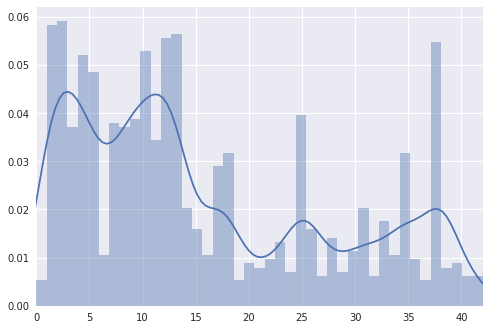

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font='DejaVu Sans') 

hist = sns.distplot(y_train, bins=43)
plt.xlim(0, 42) 
plt.show()


In [3]:
### pre-processing code from Yadav (google search)
import numpy as np
import cv2
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg

def augment_brightness_camera_images(image):
    #outimageHSV = np.uint8(image)
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    
    # Brightness 
    

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    #img = augment_brightness_camera_images(img) ### brightness not helping as much.. removing this from augmentation
    
    return img

3


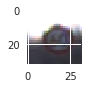

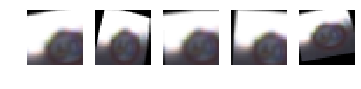

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

gs1 = gridspec.GridSpec(10, 10)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 
plt.figure(figsize=(12,12))
for i in range(5):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    img = transform_image(image,20,10,5)
    plt.subplot(10,10,i+1)
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [5]:
### storing original images from the German Traffic dataset

X_train_original=X_train
X_valid_original=X_valid
X_test_original=X_test

### Augmenting images to the training data set #####

X_train_augmented=[]
y_train_augmented=[]

## plain plus augmented images generation

ind=-1 # simple index ctr
n=9 # number of augmented images to generate

for im in X_train_original:
    X_train_augmented.append(im)
    ind=ind+1
    y_train_augmented.append(y_train[ind])
    for i in range(n): 
        X_train_augmented.append(transform_image(im,15,8,3)) # generate augmented images
        y_train_augmented.append(y_train[ind]) # maintain y labels for augmented images
        
print()
print("Image Shape: {}".format(X_train_augmented[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train_augmented)))
print("Training Labels:   {} labels".format(len(y_train_augmented)))
print("Validation Set: {} samples".format(len(X_valid)))
print("Test Set:       {} samples".format(len(X_test)))

X_train=np.asarray(X_train_augmented)
y_train=np.asarray(y_train_augmented)
    


Image Shape: (32, 32, 3)

Training Set:   347990 samples
Training Labels:   347990 labels
Validation Set: 4410 samples
Test Set:       12630 samples


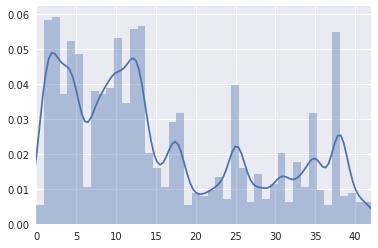

In [6]:
## confirm distribution of data post augmentation
#sns.set(font='DejaVu Sans') 
hist = sns.distplot(y_train, bins=43)
plt.xlim(0, 42) 
plt.show()

#### Normalize images post augmentation #########
def normalize(X):
    return((X/127.5)-1)

X_train=normalize(X_train)
X_valid=normalize(X_valid_original)
X_test=normalize(X_test_original)

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Training Labels:   {} labels".format(len(y_train_augmented)))
print("Validation Set: {} samples".format(len(X_valid)))
print("Test Set:       {} samples".format(len(X_test)))
print()

print("Are all values bet 0 and 255? ",(X_train > -1).all() and (X_train < 256).all())
for t in range(5):
    index = random.randint(0, len(X_train))
    print(y_train_augmented[index])
    image = X_train[index].squeeze()
    plt.figure(figsize=(1,1))
    plt.imshow(image, cmap="gray")
    print()

## Preprocess Data

Shuffle the training data.

You do not need to modify this section.

In [7]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

## Setup TensorFlow
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

You do not need to modify this section.

In [8]:
import tensorflow as tf



## SOLUTION: Implement LeNet-5
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

This is the only cell you need to edit.
### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [9]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    

    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x36.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 36), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(36))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x36. Output = 14x14x36.
    conv1 = tf.nn.avg_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    #conv1=tf.nn.dropout(conv1,keep_prob=0.5)    

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 36, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.avg_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    #conv2=tf.nn.dropout(conv2,keep_prob=0.7)

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)    
    
    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    
    fc2=tf.nn.dropout(fc2,keep_prob=0.75)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b    
       
    return logits

## Features and Labels
Train LeNet to classify [MNIST](http://yann.lecun.com/exdb/mnist/) data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

You do not need to modify this section.

In [10]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.

You do not need to modify this section.

In [11]:
rate = 0.001
EPOCHS = 7
BATCH_SIZE = 250
beta=0.01 # for L2 normalization

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

train_loss_history = []
valid_loss_history = []

train_acc_history = []
valid_acc_history = []

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

You do not need to modify this section.

In [12]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        #accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        loss, accuracy = sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return total_loss/num_examples, total_accuracy/num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

You do not need to modify this section.

Training...

EPOCH 1 ...
Validation Accuracy = 0.355
Train Accuracy = 0.321

EPOCH 2 ...
Validation Accuracy = 0.705
Train Accuracy = 0.659

EPOCH 3 ...
Validation Accuracy = 0.851
Train Accuracy = 0.813

EPOCH 4 ...
Validation Accuracy = 0.885
Train Accuracy = 0.865

EPOCH 5 ...
Validation Accuracy = 0.922
Train Accuracy = 0.906

EPOCH 6 ...
Validation Accuracy = 0.939
Train Accuracy = 0.923

EPOCH 7 ...
Validation Accuracy = 0.946
Train Accuracy = 0.943

Model saved



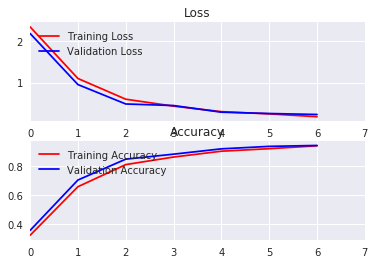

In [13]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_loss, validation_accuracy = evaluate(X_valid, y_valid)
        valid_loss_history.append(validation_loss)
        valid_acc_history.append(validation_accuracy)
        
        train_loss, train_accuracy = evaluate(X_train, y_train)
        train_loss_history.append(train_loss)
        train_acc_history.append(train_accuracy)
            
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Train Accuracy = {:.3f}".format(train_accuracy))
        print()        
        
    saver.save(sess, 'sankar_model')
    print("Model saved")
    
    loss_plot = plt.subplot(2,1,1)
    loss_plot.set_title('Loss')
    loss_plot.plot(train_loss_history, 'r', label='Training Loss')
    loss_plot.plot(valid_loss_history, 'b', label='Validation Loss')
    loss_plot.set_xlim([0, EPOCHS])
    loss_plot.legend(loc=2)
    print()
    acc_plot = plt.subplot(2,1,2)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(train_acc_history, 'r', label='Training Accuracy')
    acc_plot.plot(valid_acc_history, 'b', label='Validation Accuracy')
    acc_plot.set_xlim([0, EPOCHS])
    acc_plot.legend(loc=2)

## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

You do not need to modify this section.

In [14]:
with tf.Session() as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    new_saver = tf.train.import_meta_graph('sankar_model.meta')  
    new_saver.restore(sess, tf.train.latest_checkpoint('.')) 

    test_loss,test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.916


NoEntry.jpg


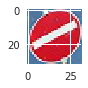

Pedestrians.jpg


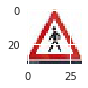

turnRight.jpg


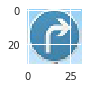

BumpyRoad.jpg


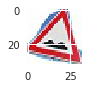

SL80.jpg


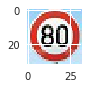

Image array shape is  (5, 32, 32, 3)
Image array data_type is  uint8
Are all values bet 0 and 255?  True


In [15]:
## Testing with new downloaded images from google

import os
from PIL import Image

new_images_folder = './FormattedPics/'
listing = os.listdir(new_images_folder)
true_labels=np.array([17,27,33,22,5]) ## NoEntry,Pedestrians,turnRight,BumpyRoad,SL80
image_array=np.array([],dtype='uint8')

### visualize images
for i, file in enumerate(listing):
    print(file)
    new_image =Image.open(new_images_folder + file)
    new_image.load()
    new_imagenp=np.asarray(new_image)
    plt.figure(figsize=(1,1))
    plt.imshow(new_imagenp)
    plt.show()
    image_array=np.append(image_array,new_imagenp)    

image_array = np.reshape(image_array, [5, 32, 32, 3])
print("Image array shape is ",image_array.shape)
print("Image array data_type is ",image_array.dtype)
print("Are all values bet 0 and 255? ",(image_array > -1).all() and (image_array < 256).all())


In [16]:
## Evaluate accuracy with new images (image_array) and true_labels

with tf.Session() as sess:
      
    new_saver = tf.train.import_meta_graph('sankar_model.meta')  
    new_saver.restore(sess, tf.train.latest_checkpoint('.'))        
    my_loss,my_accuracy = evaluate(image_array, true_labels)
    print("Internet Images Accuracy = {:.3f}".format(my_accuracy))    
    print()
    predicted_logits = sess.run(logits, feed_dict={x: image_array})
    result=sess.run(tf.nn.softmax(predicted_logits))
    
    values, indices = tf.nn.top_k(result, 5)
    probs = sess.run(values)
    predictions = sess.run(indices)
    
    np.set_printoptions(formatter={'float': lambda probs: "{0:0.7f}".format(probs)})    
    print("softmax probabilties for top 5 predictions are:")
    print(probs)
    print()
    print("top 5 predictions are:")
    print(predictions)
    print()
    true_labels=np.array([17,27,33,22,5]) ## NoEntry,Pedestrians,turnRight,BumpyRoad,SL80 
    print("Actual Labels are:",true_labels)

    #true_labels=np.array([17,27,33,22,5]) ## NoEntry,Pedestrians,turnRight,BumpyRoad,SL80 

Internet Images Accuracy = 0.600

softmax probabilties for top 5 predictions are:
[[0.9987065 0.0012936 0.0000000 0.0000000 0.0000000]
 [0.9999481 0.0000505 0.0000007 0.0000006 0.0000000]
 [0.9838904 0.0161041 0.0000036 0.0000019 0.0000000]
 [1.0000000 0.0000000 0.0000000 0.0000000 0.0000000]
 [0.8952584 0.1044102 0.0003234 0.0000080 0.0000000]]

top 5 predictions are:
[[17 14 29 12  0]
 [18 24 26 27 25]
 [40 37 33 35 39]
 [22  9 29 26 18]
 [ 5  3  2  1  7]]

Actual Labels are: [17 27 33 22  5]


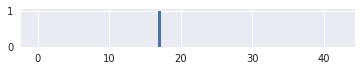

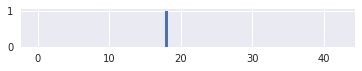

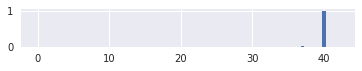

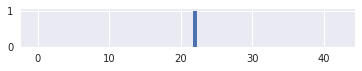

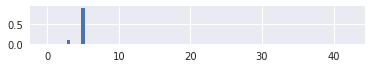

In [17]:
## plot softmax probabilities

width = 0.5
x_vals = range(43)
for i in range(5):
    fig = plt.figure()
    ax = fig.add_subplot(5,1,i+1)
    ax.bar(x_vals, result[i], width)
    plt.show()